In [286]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize

# Numerical differentiation packages
import numdifftools as ndt

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Our main MCMC package
import emcee

# Corner is useful for displaying MCMC results
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

## Tidying data, preliminary function definitions

In [3]:
competition_data = pd.read_csv('data/rasson_et_al/rasson_competition_anisotropy.csv', delimiter=',',
                              comment='#')
dissociation_data = pd.read_csv('data/rasson_et_al/rasson_dissociation_anisotropy.csv', delimiter=',',
                              comment='#')

# Take a look. The data set is small, so don't bother using head()
dissociation_data

,[SDfluor] (uM),[actin] (uM) trial 1,anisotropy trial 1,[actin] (uM) trial 2,anisotropy trial 2
0,0.005,31.100,115.2,16.00,126.3
1,NaN,16.550,114.0,8.00,128.4
2,NaN,8.280,113.9,4.00,126.4
3,NaN,4.140,112.7,2.00,122.4
4,NaN,2.070,109.0,1.00,119.7
5,NaN,1.030,103.7,0.50,115.1
6,NaN,0.517,99.6,0.25,109.0
7,NaN,0.129,83.4,0.25,107.5
8,NaN,0.000,58.9,0.00,76.3


This is very messy, in a way that just melting will not fix.

In [4]:
# Set all values for actin concentration to the value of the first non-NaN actin concentration in the file
competition_data['[actin] (uM)'] = competition_data['[actin] (uM)'][np.isnan(competition_data['[actin] (uM)']) == False][0]
# Same for SDfluor conc.
competition_data['[SDfluor] (uM)'] = competition_data['[SDfluor] (uM)'][np.isnan(competition_data['[SDfluor] (uM)']) == False][0]

competition_data.columns = ['actin_conc', 'sdfluor_conc', 'sd_conc', 1, 2, 3, 4]

competition_data = pd.melt(competition_data, value_vars=[1, 2, 3, 4],
                           id_vars=['actin_conc', 'sdfluor_conc'], var_name='trial', value_name='anisotropy')

# Check
competition_data.head()

,actin_conc,sdfluor_conc,trial,anisotropy
0,2,0.005,1,74.8
1,2,0.005,1,76.6
2,2,0.005,1,76.8
3,2,0.005,1,74.7
4,2,0.005,1,79.1


In [5]:
# Same for dissociation SDfluor concentrations, but not possible to do with melt
dissociation_data['[SDfluor] (uM)'] = dissociation_data['[SDfluor] (uM)'][np.isnan(dissociation_data['[SDfluor] (uM)']) == False][0]
dissociation_data.columns = [ 'sdfluor_conc', 'actin_conc_1', 1, 'actin_conc_2', 2]

dissociation_data_1 = pd.DataFrame([dissociation_data['sdfluor_conc'], dissociation_data['actin_conc_1'], dissociation_data[1]])
dissociation_data_1 = dissociation_data_1.transpose()
dissociation_data_1['experiment'] = 1
dissociation_data_1.columns = ('sdfluor_conc', 'actin_conc', 'anisotropy', 'experiment')

dissociation_data_2 = pd.DataFrame([dissociation_data['sdfluor_conc'], dissociation_data['actin_conc_2'], dissociation_data[2]])
dissociation_data_2 = dissociation_data_2.transpose()
dissociation_data_2['experiment'] = 2
dissociation_data_2.columns = ('sdfluor_conc', 'actin_conc', 'anisotropy', 'experiment')

dissociation_data = dissociation_data_1.append(dissociation_data_2, ignore_index=True)
dissociation_data

,sdfluor_conc,actin_conc,anisotropy,experiment
0,0.005,31.100,115.2,1
1,0.005,16.550,114.0,1
2,0.005,8.280,113.9,1
3,0.005,4.140,112.7,1
4,0.005,2.070,109.0,1
5,0.005,1.030,103.7,1
6,0.005,0.517,99.6,1
7,0.005,0.129,83.4,1
8,0.005,0.000,58.9,1
9,0.005,16.000,126.3,2


\begin{align}
c_{ad^*} = \frac{1}{2}\left(K_d^* + c_a^0 + c_{d^*}^0 - \sqrt{\left(K_d^* + c_a^0 + c_{d^*}^0\right)^2 - 4c_a^0c_{d^*}^0}\right),
\end{align}

In [57]:
# Function to compute c_ad for dissociation reactions
def c_ad_dissoc(K_d, c_a_0, c_d_0):
    """
    Compute equilibrium concentration of actin-S_D for a given value of c_a_0, c_d_0 and K_d.
    Modified from one given in problem statement to use analytical solution rather than np.roots
    """
    
    return (K_d + c_a_0 + c_d_0 - np.sqrt((K_d + c_a_0 + c_d_0)**2 - 4*c_a_0*c_d_0))/2
# Using np.roots
#     poly_coeffs = np.array([1.0, 
#                             -(K_d + c_a_0 + c_d_0), 
#                             c_a_0 * c_d_0])
    
#     return np.roots(poly_coeffs).min()

c_ad_dissoc(0, 1, 1)

1.0

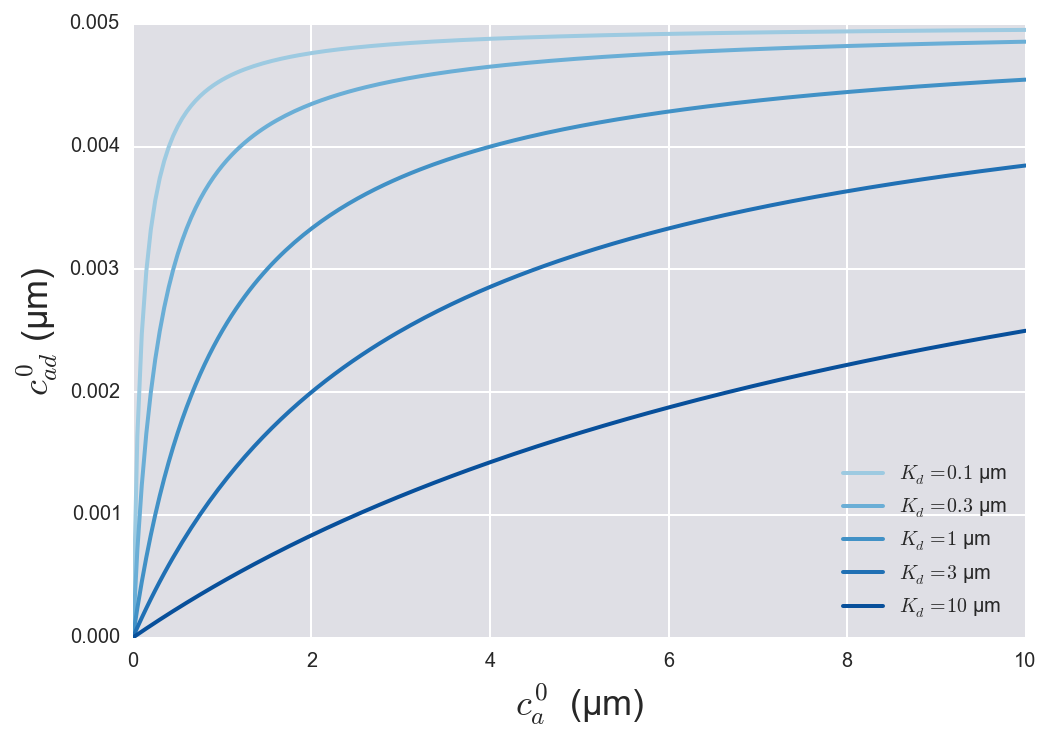

In [7]:
# Values of K_d to consider, units of micromolar (uM)
K_d = [0.1, 0.3, 1.0, 3.0, 10.0]

# Fixed S_D concentration, units of micromolar (uM)
c_d_0 = 0.005

# Varied actin concentration for plotting (uM)
c_a_0 = np.linspace(0.0, 10.0, 200)

# Make curves and plot
colors = sns.color_palette('Blues', 7)
for i in range(len(K_d)):
    # Compute c_ad over the values of c_a_0.
    c_ad = np.empty_like(c_a_0)
    for j in range(len(c_a_0)):
        c_ad[j] = c_ad_dissoc(K_d[i], c_a_0[j], c_d_0)

    # Make plot
    label = u'$K_d = %g$ µm' % K_d[i]
    plt.plot(c_a_0, c_ad, '-', color=colors[i+2], label=label)
    plt.xlabel(u'$c_a^0$ (µm)')
    plt.ylabel(u'$c_{ad}^0$ (µm)')
    plt.legend(loc='lower right')

## 4.5a
When performing a regression on a titration curve, a Jeffreys prior is appropriate for a dissociation constant.  Give a physical explanation why.  *Hint*: Think back to general chemistry.

The dissociation constant can range from 0 to +$\infty$, because $K_d = \frac{c_a c_d}{c_{ad}}$ and concentrations of each species must be positive. Also, we could have chosen to parameterise the curve in terms of $K_a = K_d^{-1}$ instead of $K_d$. Therefore we require $P(K_d|I) = P(K_a\mid I)\left\lvert\frac{\text{d}K_a}{\text{d}K_d}\right\rvert$.

A Jeffreys prior is the least informative prior in these conditions, when there is a lower bound of zero, and no upper bound. It is equivalent to a uniform prior on the logarithm of K_d, which translates to a Jeffreys prior.

## 4.5b
The file `rasson_dissociation_anisotropy.csv` contains two data sets for titrations where $c_{d^*}^0$ was held constant at 5 nM and monomeric actin was titrated.  For each $c_a^0$, the fluorescence anisotropy was measured.  For each of the two data sets, perform a regression to compute $K_d^*$ and its error bar. 

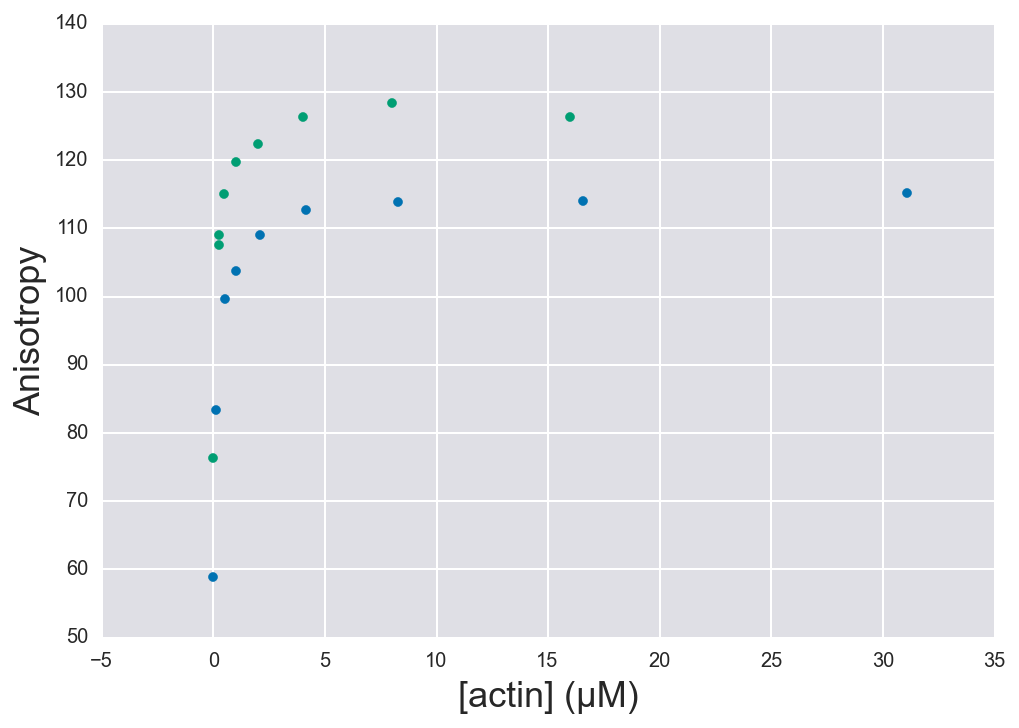

In [14]:
# Plot raw data
colors = sns.color_palette('colorblind', 2)
for i in range(1,3):
    label = u'Experiment %g' % i
    plt.scatter(dissociation_data['actin_conc'][dissociation_data['experiment']==i],
                dissociation_data['anisotropy'][dissociation_data['experiment']==i],
                color=colors[i-1], label=label)
    plt.xlabel(u'[actin] (µM)')
    plt.ylabel(u'Anisotropy')

It looks like r_f is about 50-80, r_b is about 110-130. We will use this for the initial guesses for our regression.

We need to run a regression for $K_{d^*}$, $r_f$ and $r_b$. The function we need to fit is 
\begin{align}
r = \frac{1}{c_{d^*}^0}\,\left(r_f c_{d^*} + r_b c_{ad^*}\right).
\end{align}

In [28]:
# Returns anisotropy from dissociation experiment.
def dissociation_anisotropy(K_d_star, c_a_0, c_d_star_0, r_f, r_b):
    """
    Returns anisotropy measured from dissociation experiment.
    """
    c_ad_star = c_ad_dissoc(K_d_star, c_a_0, c_d_star_0)
    # Compute anisotropy
    return r_f + (r_b-r_f) * c_ad_star / c_d_star_0

Plot function to test that it looks like we expect:

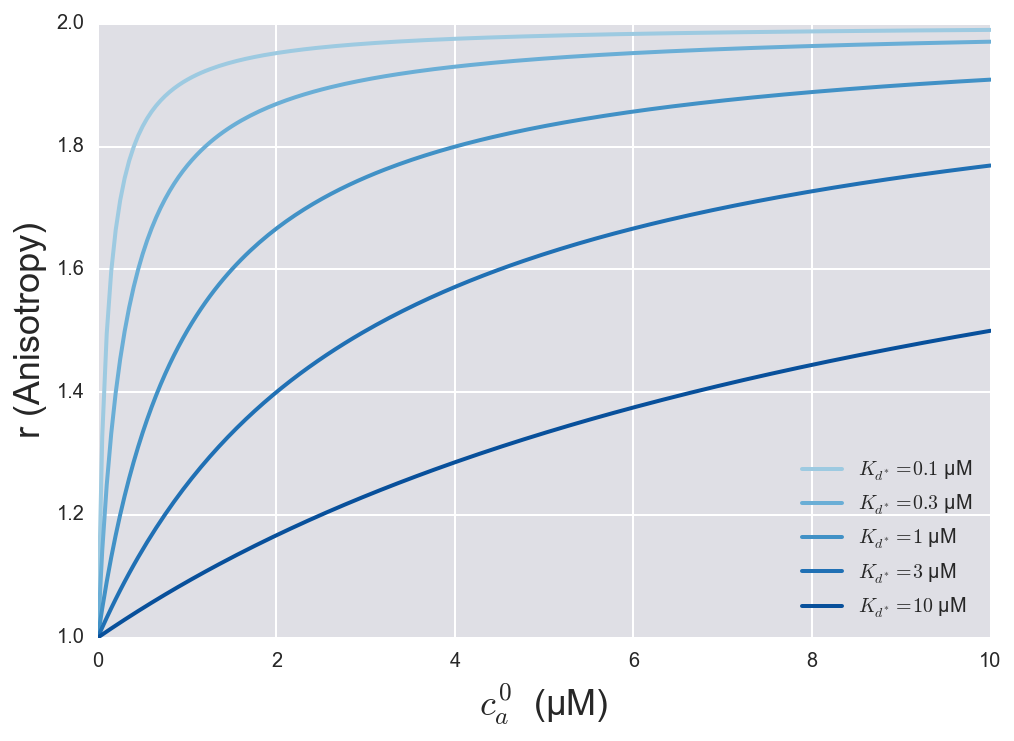

In [279]:
# Values of K_d to consider, units of micromolar (uM)
K_d_star = [0.1, 0.3, 1.0, 3.0, 10.0]

# Fixed S_D concentration, units of micromolar (uM)
c_d_star_0 = 0.005

# Varied actin concentration for plotting (uM)
c_a_0 = np.linspace(0.0, 10.0, 200)

r_f = 1

# r_b must be greater than r_f!
r_b = 2

# Make curves and plot
colors = sns.color_palette('Blues', 7)
for i in range(len(K_d)):
    # Compute c_ad over the values of c_a_0.
    c_ad_star = np.empty_like(c_a_0)
    for j in range(len(c_a_0)):
        c_ad_star[j] = dissociation_anisotropy(K_d_star[i], c_a_0[j], c_d_star_0, r_f, r_b)

    # Make plot
    label = u'$K_{d^*} = %g$ µM' % K_d_star[i]
    _ = plt.plot(c_a_0, c_ad_star, '-', color=colors[i+2], label=label)
    _ = plt.ylabel(u'r (Anisotropy)')
    _ = plt.xlabel(u'$c_{a}^0$ (µM)')
    _ = plt.legend(loc='lower right')

Now we have to run a regression. First state Bayes' theorem:

\begin{align}
\text{P}(K_d^*, r_b, r_f \mid r, I) = \frac{\text{P}(r \mid K_d^*, r_b, r_f, I) \text{P}(K_d^*, r_b, r_f \mid I)}{\text{P}(r \mid I)}
\end{align}

Likelihood:
\begin{align}
\text{P}(r \mid K_d^*, r_b, r_f, I) &= \prod_{i\in D}\frac{1}{\sqrt{2\pi \sigma^2}} \text{exp}\left[-\frac{(x_i-\mu)^2}{2\sigma^2}\right]\\
\text{where } \mu &= r_f + \frac{r_b-r_f}{c_{d^*}^0}c_{ad^*}
\end{align}

Prior:
We assume independence of $K_d^*$, $r_b$ and $r_f$, even though we know that $r_b > r_f$. The likelihood should deal with this.
\begin{align}
\text{P}(K_d^*, r_b, r_f \mid I) &= \text{P}(K_d^* \mid I)\text{P}(r_b^* \mid I)\text{P}(r_f^* \mid I) & \text{assuming independence}\\
&= \left\{
\begin{array}{c l}      
    \frac{1}{K_d^* r_b r_f} & r_b > r_f\\
    0 & \text{otherwise}
\end{array} \right.
\\
\end{align}

Posterior (un-normalised):
\begin{align}
\text{P}(K_d^*, r_b, r_f \mid r, I) = \left\{
\begin{array}{c l}      
    \frac{1}{K_d^* r_b r_f}\prod_{i\in D}\frac{1}{\sqrt{2\pi \sigma^2}} \text{exp}\left[-\frac{x_i-\left(r_f + \frac{r_b-r_f}{c_{d^*}^0}c_{ad^*}\right)^2}{2\sigma^2}\right] & r_b > r_f\\
    0 & \text{otherwise}
\end{array} \right.
\end{align}

Log Posterior (un-normalised):
\begin{align}
\text{log}(\text{P}(K_d^*, r_b, r_f \mid r, I)) = \left\{
\begin{array}{c l}      
    \text{log}(\frac{1}{K_d^* r_b r_f}) + \text{log}(\frac{1}{\sqrt{2\pi \sigma^2}}) + \sum_{i\in D}-\frac{r_i-\left(r_f + \frac{r_b-r_f}{c_{d^*}^0}c_{ad^*}\right)^2}{2\sigma^2} & r_b > r_f\\
    0 & \text{otherwise}
\end{array} \right.
\end{align}

In [207]:
def resid(p, c_a_0, c_d_star_0, r):
    """
    Residuals for anisotropy model.
    """
    # Unpack parameters
    K_d_star, r_f, r_b, variance = p
    
    # Theoretical anisotropy
    r_theor = dissociation_anisotropy(K_d_star, c_a_0, c_d_star_0, r_f, r_b)
    return r - r_theor

def log_post(p, c_a_0, c_d_star_0, r):
    """
    Compute log of posterior for single set of parameters.
    p[0] = K_d_star
    p[1] = r_f
    p[2] = r_b
    p[3] = sigma^2
    """
    # Unpack parameters
    K_d_star, r_f, r_b, variance = p
    
    #Residuals
    residual = resid(p, c_a_0, c_d_star_0, r)

    if (r_b <= r_f) | (K_d_star <= 0) | (r_f <= 0) :
        return -np.inf
    else:
#         print(p)
        log_posterior=np.log(1/(K_d_star*r_b*r_f)) + np.log(1/np.sqrt(2*np.pi*(variance))) - \
                np.sum((residual)**2)/(2*(variance))
#         print(log_posterior)
        return log_posterior

def neg_log_post(p, c_a_0, c_d_star_0, r):
    return -log_post(p, c_a_0, c_d_star_0, r)

In [141]:
experiment1_curve = pd.DataFrame(scipy.optimize.leastsq(resid, [5, 60, 120, 1], args=(dissociation_data[dissociation_data['experiment']==1]['actin_conc'], 0.005,
            dissociation_data[dissociation_data['experiment']==1]['anisotropy']))[0])
experiment1_curve = experiment1_curve.transpose()
experiment1_curve.columns = ('K_d_star', 'r_f', 'r_b', 'variance')
experiment1_curve

,K_d_star,r_f,r_b,variance
0,0.184957,59.385583,114.462283,1


In [99]:
experiment2_curve = pd.DataFrame(scipy.optimize.leastsq(resid, [5, 60, 120, 1], args=(dissociation_data[dissociation_data['experiment']==2]['actin_conc'], 0.005,
            dissociation_data[dissociation_data['experiment']==2]['anisotropy']))[0])
experiment2_curve = experiment2_curve.transpose()
experiment2_curve.columns = ('K_d_star', 'r_f', 'r_b', 'variance')
experiment2_curve

,K_d_star,r_f,r_b,variance
0,0.154691,76.388254,127.522043,1


Let's overlay these on the data:

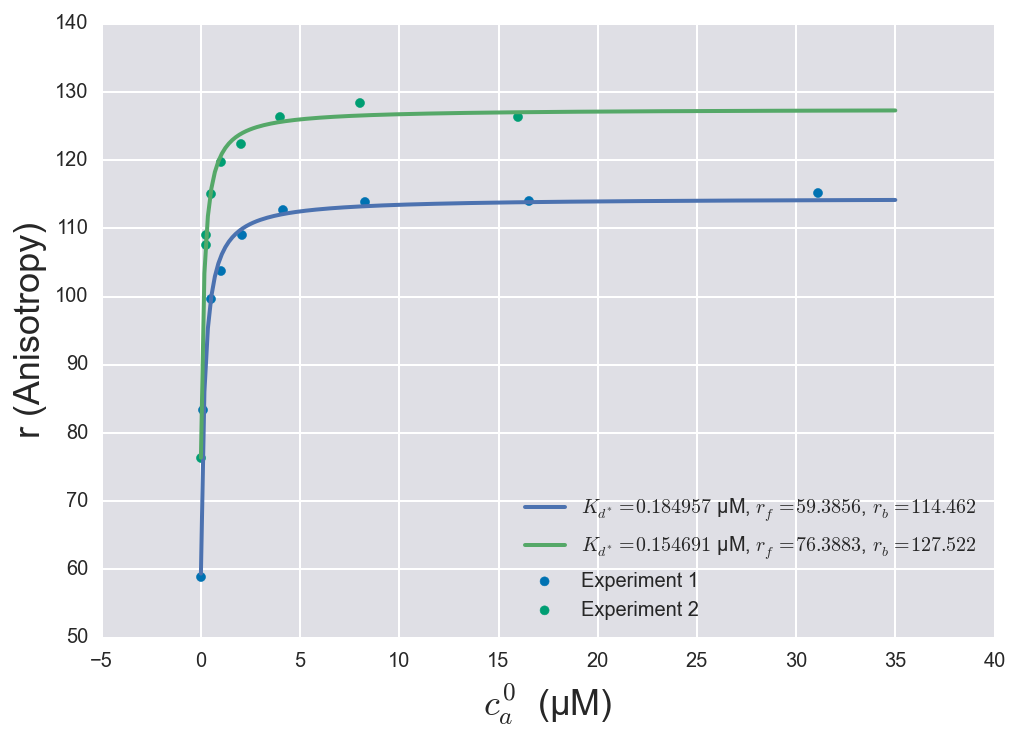

In [82]:
# Plot raw data
colors = sns.color_palette('colorblind', 2)
for i in range(1,3):
    label = u'Experiment %g' % i
    plt.scatter(dissociation_data['actin_conc'][dissociation_data['experiment']==i],
                dissociation_data['anisotropy'][dissociation_data['experiment']==i],
                color=colors[i-1], label=label)
    plt.xlabel(u'[actin] (µM)')
    plt.ylabel(u'Anisotropy')

    
c_a_0 = np.linspace(0.0, 35.0, 200)
c_d_star_0 = 0.005


# Make curves and plot
for i, curve in enumerate([experiment1_curve, experiment2_curve]):
    # Compute c_ad over the values of c_a_0.
    c_ad_star = np.empty_like(c_a_0)
    for j in range(len(c_a_0)):
        c_ad_star[j] = dissociation_anisotropy(curve['K_d_star'], c_a_0[j], c_d_star_0, curve['r_f'], curve['r_b'])

    # Make plot
    label = u'$K_{d^*} = %g$ µM, $r_f = %g$, $r_b = %g$' % (curve['K_d_star'], curve['r_f'], curve['r_b'])
    _ = plt.plot(c_a_0, c_ad_star, '-', label=label)
    _ = plt.ylabel(u'r (Anisotropy)')
    _ = plt.xlabel(u'$c_{a}^0$ (µM)')
    _ = plt.legend(loc='lower right')

$\sigma$ comes out as 1 in both cases, which is the same as my initial guess for variance. This is because I am only optimizing the residuals, not the whole function. Therefore the maximum value doesn't depend on sigma ($\frac{\text{d(residual)}}{\text{d(variance)}}=0$) so the variance won't be optimized at all. I need to optimize the whole posterior function instead.

In [231]:
# Not starting exactly on results from before so I can check that my output is doing something.
experiment1_curve_minimize = \
    scipy.optimize.minimize(neg_log_post, [0.1, 50, 110, 10],
                            args=(dissociation_data[dissociation_data['experiment']==1]['actin_conc'],
                                  0.005,
                                  dissociation_data[dissociation_data['experiment']==1]['anisotropy']))
experiment1_curve_minimize = pd.DataFrame(experiment1_curve_minimize['x']).transpose()
experiment1_curve_minimize.columns = ('K_d_star', 'r_f', 'r_b', 'variance')

experiment2_curve_minimize = \
    scipy.optimize.minimize(neg_log_post, [0.15, 76, 127, 10],
                            args=(dissociation_data[dissociation_data['experiment']==2]['actin_conc'],
                                  0.005,
                                  dissociation_data[dissociation_data['experiment']==2]['anisotropy']))
experiment2_curve_minimize = pd.DataFrame(experiment2_curve_minimize['x']).transpose()
experiment2_curve_minimize.columns = ('K_d_star', 'r_f', 'r_b', 'variance')


experiment1_curve_minimize


,K_d_star,r_f,r_b,variance
0,0.169727,58.688311,114.144896,12.412508


The results are not exactly the same as before, but close. This is because $K_d^*$, $r_f$ and $r_b$ depend on the variance.

In [232]:
experiment2_curve_minimize

,K_d_star,r_f,r_b,variance
0,0.145804,75.950336,127.23941,9.767192


Let's overlay these on the data:

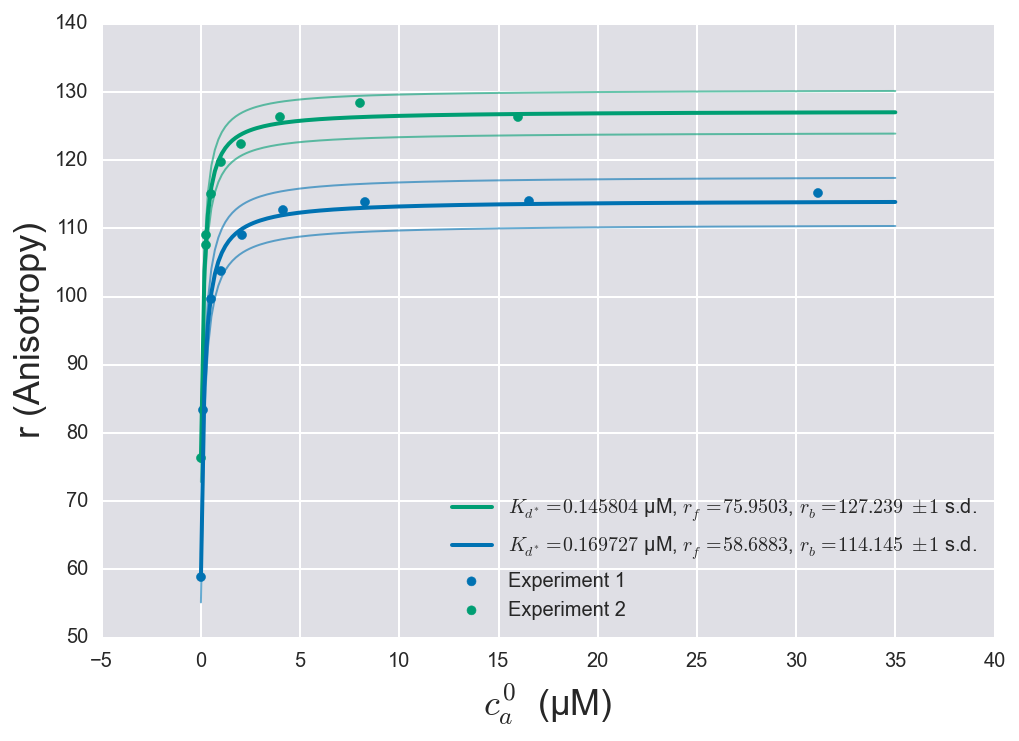

In [283]:
# Plot raw data
colors = sns.color_palette('colorblind', 2)
for i in range(1,3):
    label = u'Experiment %g' % i
    plt.scatter(dissociation_data['actin_conc'][dissociation_data['experiment']==i],
                dissociation_data['anisotropy'][dissociation_data['experiment']==i],
                color=colors[i-1], label=label)
    plt.xlabel(u'[actin] (µM)')
    plt.ylabel(u'Anisotropy')

    
c_a_0 = np.linspace(0.0, 35.0, 200)
c_d_star_0 = 0.005


# Make curves and plot
for i, curve in enumerate([experiment2_curve_minimize, experiment1_curve_minimize, ]):
    # Compute c_ad over the values of c_a_0.
    c_ad_star = np.empty_like(c_a_0)
    # I didn't like the way using plt.errorbar displayed, so I manually
    # plotted the high and low errors
    error = np.sqrt(curve['variance'])
    error_high = np.empty_like(c_a_0)
    error_low = np.empty_like(c_a_0)
    for j in range(len(c_a_0)):
        c_ad_star[j] = dissociation_anisotropy(curve['K_d_star'],
                                               c_a_0[j], c_d_star_0, curve['r_f'], curve['r_b'])
        error_high[j] = c_ad_star[j]+error
        error_low[j] = c_ad_star[j]-error
    # Make plot
    label = u'$K_{d^*} = %g$ µM, $r_f = %g$, $r_b = %g$ $\pm 1$ s.d.' % (curve['K_d_star'], curve['r_f'], curve['r_b'])
    _ = plt.plot(c_a_0, c_ad_star, '-', label=label, color=colors[i-1])
    _ = plt.plot(c_a_0, error_high, color=colors[i-1], alpha=0.6, lw=1)
    _ = plt.plot(c_a_0, error_low, color=colors[i-1], alpha=0.6, lw=1)
    _ = plt.ylabel(u'r (Anisotropy)')
    _ = plt.xlabel(u'$c_{a}^0$ (µM)')
    _ = plt.legend(loc='lower right')

## MCMC
Didn't work, please ignore

In [201]:
# Small values for initial testing
n_dim = 4        # number of parameters in the model (K_d_star, r_f, r_b)
n_walkers = 8   # number of MCMC walkers
n_burn = 50     # "burn-in" period to let chains stabilize
n_steps = 50   # number of MCMC steps to take after burn-in

# p0[i,j] is the starting point for walk i along variable j.
# Start slightly away from MAP so I can see the values change.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = 0.16            # K_d_star
p0[:,1] = 58             # r_f
p0[:,2] = 110             # r_b
p0[:,3] = 10             # variance

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, 
                                args=(dissociation_data[dissociation_data['experiment']==1]['actin_conc'], 0.005,
            dissociation_data[dissociation_data['experiment']==1]['anisotropy']))

In [202]:
p0

array([[   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ]])

In [203]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=True)
p0

In [204]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

(8, 100, 4)
(800, 4)


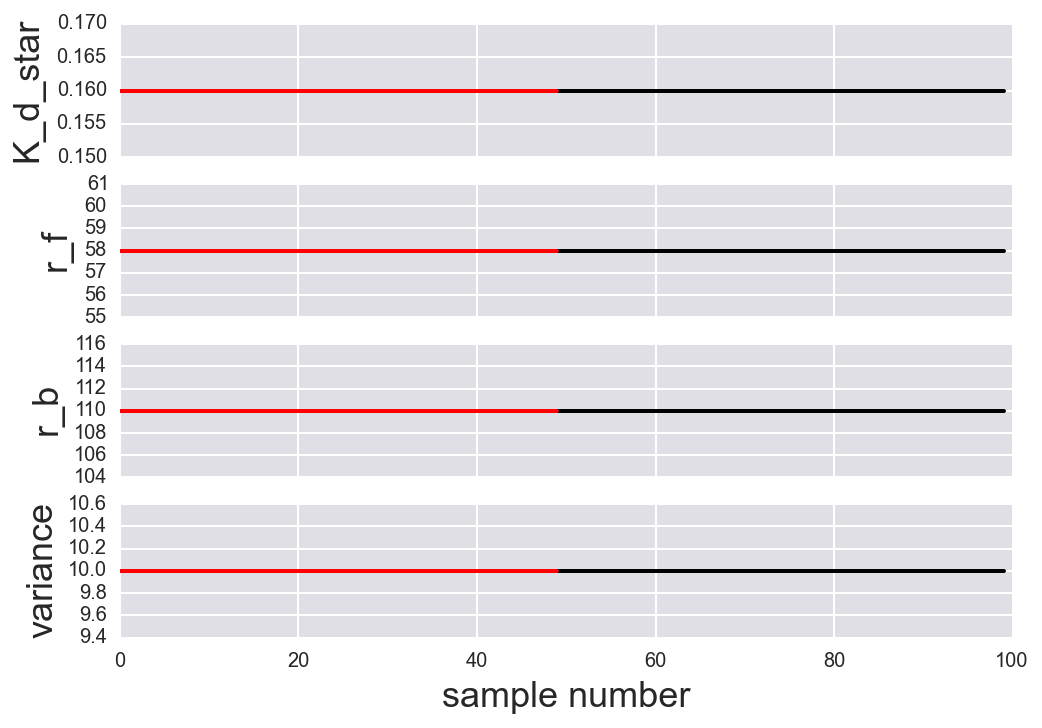

In [205]:
print(sampler.chain.shape)
print(sampler.flatchain.shape)
fig, ax = plt.subplots(4, 1, sharex=True)
for i, variable in enumerate(['K_d_star', 'r_f', 'r_b', 'variance']):
    ax[i].plot(sampler.chain[0,:,i], 'k-')
    ax[i].plot([0, n_steps-1], 
             [sampler.chain[0,:,i].mean(), sampler.chain[0,:,i].mean()], 'r-')
    ax[i].set_ylabel(variable)
plt.xlabel('sample number')

Why are the walkers not walking?
I get exactly the same values as I put start with.

In [206]:
pos

array([[   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ],
       [   0.16,   58.  ,  110.  ,   10.  ]])

## 4.5c
Treat the result of each regression as a "measurement" of $K_d^*$.  Given the two measurements, what values do we have for $K_d^*$ and its error bar?  (Note that this could be done using a hierarchical model, which we will talk about later in class.)

In problem 4.4, we calculated that
$$
    P(\mu|D,I) \sim \mathcal{N}\left(\frac{\sigma_2^2\mu_1 + \sigma_1^2\mu_2} 
        {\sigma_ 1^ 2 + \sigma_ 2 ^ 2}, 
        \frac{\sigma_1^2\sigma_2^2}{\sigma_ 1^ 2 + \sigma_ 2^ 2}\right)
$$

In [95]:
def two_measurements(mu1, variance1, mu2, variance2):
    """
    Given two means and variances from a normal distribution,
    outputs a combined mean and variance
    """
    mu = (variance2*mu1 + variance1*mu2)/(variance1 + variance2)
    sigma = (variance1 * variance2)/(variance1 + variance2)
    return (mu, sigma)

In [293]:
K_d_star1 = experiment1_curve_minimize['K_d_star'].values[0]
variance1 = experiment1_curve_minimize['variance'].values[0]
K_d_star2 = experiment2_curve_minimize['K_d_star'].values[0]
variance2 = experiment2_curve_minimize['variance'].values[0]

K_d_star_value, K_d_star_variance = two_measurements(K_d_star1, variance1, K_d_star2, variance2)
print(u'K_d* = %g +- %g' % (K_d_star_value, np.sqrt(K_d_star_variance)))

K_d* = 0.156339 +- 5.46605


## 4.5d
The file `rasson_competition_anisotropy.csv` contains four data sets of competition anisotropy experiments.  The total concentration of monomeric actin was held constant at $c_a^0 = 2$ µM.  The total concentration of $S_{D^*}$ was held constant at $c_{d^*}^0 = 5$ nM.  The total concentration of $S_D$, $c_d^0$, was varied to give the titration curve.  Perform a regression for each experiment to find a value for $K_d$.  In part (c), you found a value and error bar for $K_d^*$.  Use these values for $K_d^*$ to approximate its prior as a Gaussian in the regression of the competition anisotropy experiments.

In [284]:
competition_data.head()

,actin_conc,sdfluor_conc,trial,anisotropy
0,2,0.005,1,74.8
1,2,0.005,1,76.6
2,2,0.005,1,76.8
3,2,0.005,1,74.7
4,2,0.005,1,79.1


The problem statement defined competition_anisotropy():

In [ ]:
# Returns anisotropy from competition experiment.
def competition_anisotropy(K_d, K_d_star, c_a_0, c_d_0, c_d_star_0, r_f, r_b):
    """
    Returns anisotropy measured from competition experiment.
    """
    # Define coeffients for third order polynomial
    beta = K_d + K_d_star + c_d_0 + c_d_star_0 - c_a_0
    gamma = K_d * (c_d_star_0 - c_a_0) + K_d_star * (c_d_0 - c_a_0) \
                    + K_d * K_d_star
    delta = -K_d * K_d_star * c_a_0
    
    # Compute roots (one of them is concentration of free actin)
    poly_roots = np.roots(np.array([1.0, beta, gamma, delta]))

    # Get index of root that we want (real, between 0 and c_a_0)
    inds = (np.isreal(poly_roots)) & (0 < poly_roots) & (poly_roots < c_a_0)
    c_a = poly_roots[inds][0]

    # Compute c_d* and c_ad*
    c_ad_star = c_a * c_d_star_0 / (K_d_star + c_a)
    c_d_star = c_d_star_0 - c_ad_star
    
    # Compute anisotropy
    return (r_f * c_d_star + r_b * c_ad_star) / c_d_star_0

In [ ]:
 We need to minimize -log(posterior)

In [291]:
def resid_competition(p, c_d_0, c_d_star_0, r):
    """
    Residuals for competition model.
    """
    # Unpack parameters
    K_d, K_d_star, c_a_0, r_f, r_b, variance = p
    
    # Theoretical anisotropy
    r_theor = competition_anisotropy(K_d, K_d_star, c_a_0, c_d_0, c_d_star_0, r_f, r_b)
    return r - r_theor
resid_competition([1,0.156339,1,1,1,2],1,1,0)

-1.0

Run a regression. First state Bayes' theorem:

\begin{align}
\text{P}(D \mid r, I) &= \frac{\text{P}(r \mid D, I) \text{P}(D \mid I)}{\text{P}(r \mid I)}\\
\text{where } D &= K_d, K_d^*, c_a^0, c_{d^*}^0, r_b, r_f
\end{align}

Likelihood:
\begin{align}
\text{P}(r \mid D) &= \prod_{i\in D}\frac{1}{\sqrt{2\pi \sigma^2}} \text{exp}\left[-\frac{(r-\mu)^2}{2\sigma^2}\right]\\
\text{where } \mu &= \texttt{competition_anisotropy(K_d, K_d_star, c_a_0, c_d_0, c_d_star_0, r_f, r_b)}
\end{align}

Prior:
\begin{align}
\text{P}(D \mid I) &= \text{P}(K_d \mid I)\text{P}(K_d^* \mid I)\text{P}(c_a^0 \mid I)\text{P}(c_d^0 \mid I)\text{P}(c_d^* \mid I) & \text{assuming independence}\\
\text{P}(K_d \mid I) &= \frac{1}{K_d} & \text{Jeffreys}\\
\text{P}(K_d^* \mid I) &= \frac{1}{\sqrt{2\pi \sigma^2}} \text{exp}\left[-\frac{(K_d^*-\mu)^2}{2\sigma^2}\right] & \text{where } K_d^* = 0.156339, \sigma^2 = 5.46605\\
\text{P}(c_a^0 \mid I) &= 0.005 & \text{constant}\\
\text{P}(c_d^0 \mid I) &= \frac{1}{c_d^0} & \text{Jeffreys}\\
\text{P}(c_{d^*} \mid I) &= 2 & \text{constant}\\
\text{P}(r_f \mid I) &= \frac{1}{r_f} & \text{Jeffreys}\\
\text{P}(r_b \mid I) &= \frac{1}{r_b} & \text{Jeffreys}\\
\end{align}

Posterior (un-normalised):

\begin{align}
\text{P}(K_d, K_d^*, c_a^0, c_{d^*}^0, r_b, r_f \mid r, I) = \prod_{j \in \text{priors}}\text{P}_j\prod_{i\in D}\frac{1}{\sqrt{2\pi \sigma^2}} \text{exp}\left[-\frac{(r-\mu)^2}{2\sigma^2}\right]
\end{align}

Log Posterior (un-normalised):
\begin{align}
\text{log}(\text{P}(K_d, K_d^*, c_a^0, c_{d^*}^0, r_b, r_f \mid r, I) &= -\frac{(K_d^*-\mu)^2}{2\sigma^2} + \text{log}(\frac{0.005\times2}{\sqrt{2\pi \sigma^2} K_d c_d^0 r_f r_b}) +
\text{log}(\frac{1}{\sqrt{2\pi \sigma^2}}) + \sum_{i\in D} \left[-\frac{(r-\mu)^2}{2\sigma^2}\right]
\end{align}

In [ ]:
# This doesn't represent the log posterior function above yet, so it won't work.
def log_post(p, c_d_0, c_d_star_0, r):
    """
    Compute log of posterior for single set of parameters.
    p[0] = K_d
    p[1] = K_d_star
    p[1] = c_a_0
    p[3] = r_f
    p[4] = r_b
    p[5] = sigma^2
    """
    # Unpack parameters
    K_d, K_d_star, c_a_0, r_f, r_b, variance = p
    
    #Residuals
    residual = resid(p, c_d_0, c_d_star_0, r)

    if (r_b <= r_f) | (K_d_star <= 0) | (r_f <= 0) :
        return -np.inf
    else:
#         print(p)
        log_posterior=np.log(1/(K_d_star*r_b*r_f)) + np.log(1/np.sqrt(2*np.pi*(variance))) - \
                np.sum((residual)**2)/(2*(variance))
#         print(log_posterior)
        return log_posterior

def neg_log_post(p, c_a_0, c_d_star_0, r):
    return -log_post(p, c_a_0, c_d_star_0, r)

scipy.optimize.minimize(neg_competition_anisotropy, [0.1, 50, 110, 10],
                            args=(dissociation_data[competition_data['trial']==1]['actin_conc'],
                                  0.005,
                                  dissociation_data[competition_data['trial']==1]['anisotropy']))